This is my personal implementation of the Vision VitTransformer (https://arxiv.org/pdf/2010.11929v2.pdf). 
This approach uses the original VitTransformer architecture but applies it to images.

I documented all of my learning process in commits on the 'ViT_dev' branch, and then just merged the final result into 'main' once I was done. If you'd like
to see my struggles, please feel free to checkout ViT_dev and enjoy! 

Import packages

In [1]:
import einops

from torchsummary import summary

import torch
from torch import nn
import torchvision
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

Set device and hyperparameters of network.

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

patch_size = 16         # Patch size (P)
latent_size = 768       # Latent vector (D). ViT-Base uses 768
n_channels = 3          # Number of channels for input images
num_heads = 12          # ViT-Base uses 12 heads
num_encoders = 12       # ViT-Large uses 24 encoder layers
dropout = 0.1           # Dropout = 0.1 is used with ViT-Base & ImageNet-21k
num_classes = 10        # Number of classes in CIFAR10 dataset

epochs = 90             # Number of epochs
base_lr = 10e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)
batch_size = 4


cuda:0


Download and prepare dataset. We will use the CIFAR-10 dataset from PyTorch.
The firsts time you run this, make sure you pass your own 'root' path and use 'download=True' to
download the data. Afterwards, you can change the 'download=True' to 'download=False' since the data is already downloaded.

The cell below used to prepare the CIFAR dataset is taken almost straight from the PyTorch tutorial on training with CIFAR10: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 

In [3]:
# I resize the input data to 224x224, since that is the training resolution used in the paper.
# The mean and std values used to normalize CIFAR10 data is from here: https://github.com/kuangliu/pytorch-cifar/issues/19
transform = Compose(
    [ToTensor(), Resize((224, 224)), Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

train_data = torchvision.datasets.CIFAR10(
    root='/home/achalhoub/Desktop/ViT_CIFAR10_data', train=True, download=False, transform=transform)

test_data = torchvision.datasets.CIFAR10(
    root='/home/achalhoub/Desktop/ViT_CIFAR10_data', train=False, download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Code to visualize samples from CIFAR10 dataset. This code is from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


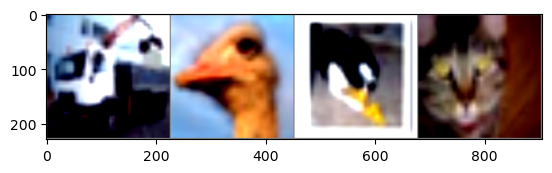

truck bird  dog   cat  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Implement Input Embedding class. This class performs all the steps needed before the data goes into the 'VitTransformer Encoder' block. This includes splitting input images into patches, performing the linear projections of the patches, pre-pending a [class] token and adding a position embedding to the linear projection. The output of this class is fed into the Encoder.

In [5]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, device=device, latent_size=latent_size, batch_size=batch_size):
        super(InputEmbedding, self).__init__()
        self.latent_size = latent_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.device = device
        self.batch_size = batch_size
        self.input_size = self.patch_size * self.patch_size * self.n_channels

        self.linearProjection = nn.Linear(self.input_size, self.latent_size)

        # Random initialization of of [class] token that
        # is prepended to the linear projection vector.
        self.class_token = nn.Parameter(torch.rand(self.batch_size, self.latent_size).unsqueeze(1)).to(self.device)

        # Embedding layer for position embedding.
        self.embeddingLayer = nn.Embedding(self.latent_size+1, self.latent_size)


    def forward(self, input):

        # Resize input images to 256x256 and convert to Pytorch tensor.
        image_transform = Compose([Resize((224, 224))])
        transformed_image = image_transform(input).to(self.device)

        # Re-arrange image into patches.
        patches = einops.rearrange(
            transformed_image, 'b c (h h1) (w w1) -> b (h w) (h1 w1 c)', h1=self.patch_size, w1=self.patch_size)

        linear_projection = self.linearProjection(patches).to(self.device)
        
        # Prepend the [class] token to the original linear projection
        #print('class_token: ', self.class_token.size())
        #print('linear_projection: ', linear_projection.size())
        new_vector = torch.cat((self.class_token, linear_projection), dim=1)

        # Create a positions vector to create the position embedding.
        positions_vector = torch.arange(0, new_vector.shape[1]).expand(
            new_vector.shape[0], new_vector.shape[1]).to(self.device)

        # Add the positional encodings to the linear vector (with the class token)
        return new_vector + self.embeddingLayer(positions_vector)

Implement the Encoder block.

In [7]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_size=latent_size, num_heads=num_heads, device=device, dropout=dropout):
        super(EncoderBlock, self).__init__()

        self.latent_size = latent_size
        self.num_heads = num_heads
        self.device = device
        self.dropout = dropout

        # First Normalization layer
        self.firstNorm = nn.LayerNorm(self.latent_size)
        
        # Multi-Head Attention layer
        self.multihead = nn.MultiheadAttention(
            self.latent_size, self.num_heads, dropout=self.dropout)           
        
        # Second Normalization layer
        self.secondNorm = nn.LayerNorm(self.latent_size) 

        #self.dropoutLayer = nn.Dropout(p=self.dropout)

        # MLP_head layer in the encoder. I use the same configuration as that 
        # used in the original VitTransformer implementation. The ViT-Base
        # variant uses MLP_head size 3072, which is latent_size*4.
        self.enc_MLP_head = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size*4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.latent_size*4, self.latent_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, embedded_patches):

        # First sublayer: Norm + Multi-Head Attention + residual connection.
        # We take the first element ([0]) of the returned output from nn.MultiheadAttention()
        # because this module returns 'Tuple[attention_output, attention_output_weights]'. 
        # Refer to here for more info: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html 
        firstNorm_out = self.firstNorm(embedded_patches)
        attention_output = self.multihead.forward(firstNorm_out, firstNorm_out, firstNorm_out)[0]

        # First residual connection
        first_added_output = attention_output + embedded_patches

        #attention_output = self.dropoutLayer(attention_output)

        # Second sublayer: Norm + MLP_head (Feed forward)
        secondNorm_out = self.secondNorm(first_added_output)
        ff_output = self.enc_MLP_head(secondNorm_out)

        # Return the output of the second residual connection
        return ff_output + first_added_output

Put together the whole Vision VitTransformer. What's added to the input embedding layer and the encoder stack here
is the output MLP head (MLP_head), which is used for classification at the end of the whole model.

In [9]:
class VitTransformer(nn.Module):
    def __init__(self, num_encoders=num_encoders, latent_size=latent_size, device=device, num_classes=num_classes):
        super(VitTransformer, self).__init__()
        self.num_encoders = num_encoders
        self.latent_size = latent_size
        self.device = device
        self.num_classes = num_classes

        self.embedding = InputEmbedding()
        self.encStack = nn.ModuleList([EncoderBlock() for i in range(self.num_encoders)])

        # MLP_head at the classification head has 'one hidden layer at pre-training time
        # and by a single linear layer at fine-tuning time'. For this implementation I will
        # use what was used for training, so I'll have a total of two layers, one hidden
        # layer and one output layer.
        self.MLP_head = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size),
            nn.Linear(self.latent_size, self.num_classes)
        )

    def forward(self, test_input):

        # Apply input embedding (patchify + linear projection + position embeding)
        # to the input image passed to the model
        enc_output = self.embedding.forward(test_input)

        # Loop through all the encoder layers
        for enc_layer in self.encStack:
            enc_output = enc_layer.forward(enc_output)

        # Finally, take last output from the encoder stack and pass it to
        # the MLP Head for classification. Look only at the vector of the first 
        # token, which is the [class] token that's used for classification. This list
        # will have 10 'percentage' values, equivalent to the number of the dataset classes.
        # We return a tensor of the following shape (batch_size, num_classes), since that
        # is the data format that the loss functions expects as input.
        # Refer to here for more details: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss
        output = self.MLP_head(enc_output)[:, 0]
        return output

In [10]:
test_input = torch.randn(3, 224, 224)
print(test_input.size())

torch.Size([3, 224, 224])


In [13]:
VitTransformer = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)

optimizer = optim.Adam(VitTransformer.parameters(), lr=base_lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.LinearLR(optimizer)

Check number of parameters of Vision Transformer model.
The output shows 86M parameters, which is the same as that of the ViT-Base variation in the paper (refer to Table 1).

In [27]:
summary(VitTransformer)

Layer (type:depth-idx)                                       Param #
├─InputEmbedding: 1-1                                        --
|    └─Linear: 2-1                                           590,592
|    └─Embedding: 2-2                                        590,592
├─ModuleList: 1-2                                            --
|    └─EncoderBlock: 2-3                                     --
|    |    └─LayerNorm: 3-1                                   1,536
|    |    └─MultiheadAttention: 3-2                          2,362,368
|    |    └─LayerNorm: 3-3                                   1,536
|    |    └─Sequential: 3-4                                  4,722,432
|    └─EncoderBlock: 2-4                                     --
|    |    └─LayerNorm: 3-5                                   1,536
|    |    └─MultiheadAttention: 3-6                          2,362,368
|    |    └─LayerNorm: 3-7                                   1,536
|    |    └─Sequential: 3-8                             

Layer (type:depth-idx)                                       Param #
├─InputEmbedding: 1-1                                        --
|    └─Linear: 2-1                                           590,592
|    └─Embedding: 2-2                                        590,592
├─ModuleList: 1-2                                            --
|    └─EncoderBlock: 2-3                                     --
|    |    └─LayerNorm: 3-1                                   1,536
|    |    └─MultiheadAttention: 3-2                          2,362,368
|    |    └─LayerNorm: 3-3                                   1,536
|    |    └─Sequential: 3-4                                  4,722,432
|    └─EncoderBlock: 2-4                                     --
|    |    └─LayerNorm: 3-5                                   1,536
|    |    └─MultiheadAttention: 3-6                          2,362,368
|    |    └─LayerNorm: 3-7                                   1,536
|    |    └─Sequential: 3-8                             

In [14]:
def main():
    VitTransformer.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if batch_idx < 500:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = VitTransformer.forward(inputs)
            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            print('batch_idx ', batch_idx, ' has loss ', loss)
            loss.backward()
            optimizer.step()
    scheduler.step()
    

In [15]:
if __name__ == "__main__":
    main()

batch_idx  0  has loss  tensor(2.1752, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx  1  has loss  tensor(59.5813, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx  2  has loss  tensor(9.6714, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx  3  has loss  tensor(91.8249, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx  4  has loss  tensor(175.1491, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx  5  has loss  tensor(360.0696, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx  6  has loss  tensor(693.5515, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx  7  has loss  tensor(160.2991, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx  8  has loss  tensor(638.4501, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx  9  has loss  tensor(363.5717, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx  10  has loss  tensor(131.3553, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx  11  has loss  tensor(175.7121, device='cuda:0', 